In [1]:
# Theses are different ways to display figures, depending on the
# environment, some may work better or some not at all:
%matplotlib inline
# %matplotlib notebook
# %matplotlib ipympl
# %matplotlib widget
#      widget, if installed and working, gives nicer inline plots
# %matplotlib nbagg
# Fix failing variable completion (for older installations):
# %config Completer.use_jedi = False

# First, Simplest Usecase

Let's optimize a simple ellipsoid function, $\sum_{i=1}^n 1000^{\frac{i-1}{n-1}}x_i^2$, whose Hessian has a condition number of $10^6$:

In [20]:
def getFitness(cache_blocking):
    x, y, z = cache_blocking
    val = int(x)**2 + int(y)**2 + z**2
    return val

In [21]:
# pip install cma  # outcomment in case the cma module is not installed
import cma

fun = getFitness # we could use `functools.partial(cma.ff.elli, cond=1e4)` to change the condition number to 1e4
x0 = 3 * [2]  # initial solution
sigma0 = 1    # initial standard deviation to sample new solutions

xopt, es = cma.fmin2(fun, x0, sigma0)

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=950744, Tue Mar 19 00:03:56 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 -2.443389460859571e+01 1.0e+00 9.62e-01  8e-01  1e+00 0:00.0
    2     14 -4.602012666584540e+01 1.4e+00 1.46e+00  1e+00  2e+00 0:00.0
    3     21 -7.171020642595607e+01 1.7e+00 1.93e+00  2e+00  2e+00 0:00.0
   22    154 -1.446298070380184e+07 3.5e+00 7.65e+02  6e+02  1e+03 0:00.0
termination on tolfacupx=1000.0 (Tue Mar 19 00:03:57 2024)
final/bestever f-value = -1.195641e+07 -1.446298e+07 after 155/154 evaluations
incumbent solution: [-1147.1320801777051, -1618.2473219532235, 2832.273570191558]
std deviation: [828.4171974024266, 641.7110819506684, 1137.6812770361034]


The return values are
- `x`, the best evaluated solution and
- `es`, the `cma.CMAEvolutionStrategy` class instance used to run the optimization.

The latter contains all available information about the run and the more complete return value under `es.result`.

In [4]:
dict(es.result._asdict())  # pretty print the named tuple as dictionary

{'xbest': array([-2.87167310e-09,  1.01212589e-09, -1.31452803e-10,  1.78113109e-11]),
 'fbest': 6.007275781813451e-16,
 'evals_best': 1652,
 'evaluations': 1673,
 'iterations': 209,
 'xfavorite': array([-1.41169995e-08,  3.35111014e-09,  3.54148923e-11,  8.49525945e-12]),
 'stds': array([3.60205633e-08, 2.74633546e-09, 3.48683303e-10, 4.05603195e-11]),
 'stop': {'tolfun': 1e-11}}

In [22]:
es.result_pretty()  # shows some pretty information and returns es.result

termination on tolfacupx=1000.0
final/bestever f-value = -1.446298e+07 -1.446298e+07 after 155/154 evaluations
incumbent solution: [-1147.1320801777051, -1618.2473219532235, 2832.273570191558]
std deviation: [828.4171974024266, 641.7110819506684, 1137.6812770361034]


CMAEvolutionStrategyResult(xbest=array([-1629.86379814, -1868.44541478,  2883.64984617]), fbest=-14462980.703801839, evals_best=154, evaluations=155, iterations=22, xfavorite=array([-1147.13208018, -1618.24732195,  2832.27357019]), stds=array([ 828.4171974 ,  641.71108195, 1137.68127704]), stop={'tolfacupx': 1000.0})

# Options and Plotting
Let's plot some data from the optimization. The above call to `cma.fmin2` has (by default) written data to the default output folder `outcmaes`. These data will be overwritten each time the function is called again. To prevent this, we could set/change the output folder with the `verb_filenameprefix` option. An effective way to find out this kind of behavior is to query the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) with a search string and read the comments in the return "value".

In [23]:
cma.CMAOptions('file')

{'signals_filename': 'cma_signals.in  # read versatile options from this file (use `None` or `""` for no file) which contains a single options dict, e.g. ``{"timeout": 0}`` to stop, string-values are evaluated, e.g. "np.inf" is valid',
 'verb_append': '0  # initial evaluation counter, if append, do not overwrite output files',
 'verb_filenameprefix': 'outcmaes\\  # output path (folder) and filenames prefix',
 'verb_log': '1  #v verbosity: write data to files every verb_log iteration, writing can be time critical on fast to evaluate functions'}

Plotting is as simple as

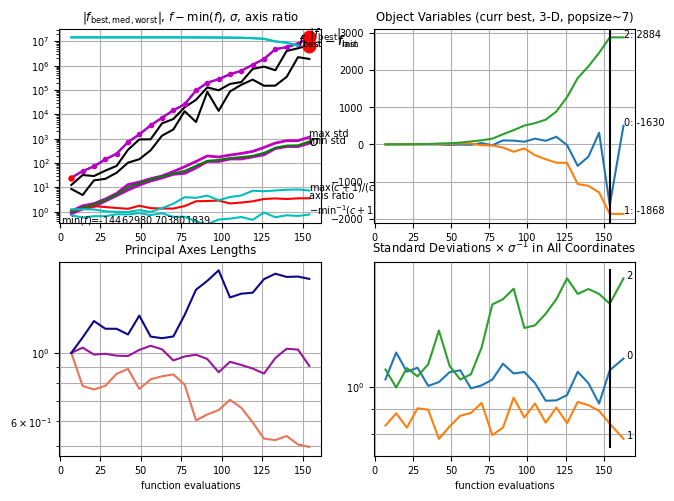

In [24]:
es.plot();  # cma.plot() does the same, as we just plot the data from the default output folder

A description of the output is given in the caption of Figure 3 in [Hansen et al (2015): Evolution Strategies](https://hal.inria.fr/hal-01155533/file/es-overview-2015.pdf#page=17).

# Options and Bound Constraints
We can add a boundary condition on any variable. We can find out how to do this, as mentioned above, by investigating the available boundary related options:

In [25]:
cma.CMAOptions('bound')  # returns options that contain "bound"

{'BoundaryHandler': 'BoundTransform  # or BoundPenalty, unused when ``bounds in (None, [None, None])``',
 'bounds': '[None, None]  # lower (=bounds[0]) and upper domain boundaries, each a scalar or a list/vector',
 'maxstd_boundrange': '1/3  # maximal std relative to bound_range per coordinate, overruled by maxstd'}

Let's bound the second variable from below to values $\ge1$ using the `'bounds'` option. In this case, we must also take care that the initial solution is within the given bounds (it is, in our case). `'bounds'` is a list of two values, `[lower_bounds, upper_bounds]`, where `lower_bounds` and `upper_bounds` can be a scalar that applies to all variables or a list. If the list is shorter than the initial solution, the last value is applied to the remaining dimensions.

In [26]:
xopt_b, es_b = cma.fmin2(fun, x0, sigma0, {'bounds': [[None, 1, None], None]})

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=885112, Tue Mar 19 00:04:46 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 -2.338446478080252e+01 1.0e+00 9.90e-01  1e+00  1e+00 0:00.0
    2     14 -6.335591197604386e+01 1.4e+00 1.71e+00  2e+00  2e+00 0:00.0
    3     21 -9.198647237388700e+01 1.6e+00 2.24e+00  2e+00  2e+00 0:00.0
   19    133 -1.958805981170569e+07 5.8e+00 7.20e+02  8e+02  1e+03 0:00.0
termination on tolfacupx=1000.0 (Tue Mar 19 00:04:46 2024)
final/bestever f-value = -1.648710e+07 -1.958806e+07 after 134/131 evaluations
incumbent solution: [3234.652318393366, 939.456390175453, 2267.497197854343]
std deviation: [1390.3114203918892, 785.0863776915119, 1059.8700719786032]


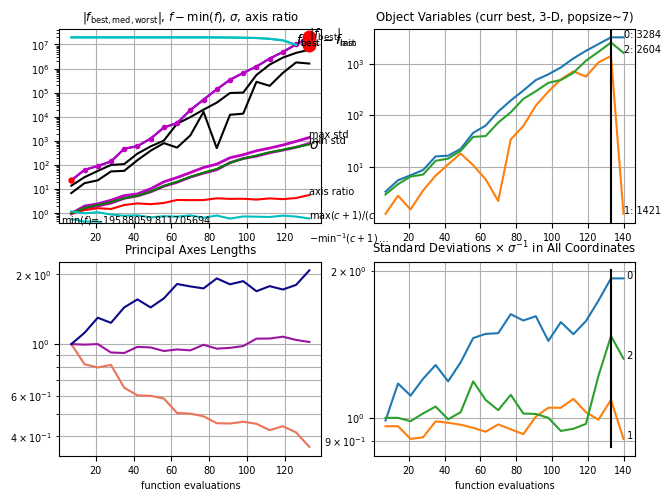

In [27]:
es.plot(xsemilog=True, x_opt=[0, 1] + (len(x0) - 2) * [0]);

### Rescaling of the Objective
In a practical application, the encoding of variables is often essential to turn a _very_ difficult problem into less difficult one, see also [here](https://cma-es.github.io/cmaes_sourcecode_page.html#practical). The simplest encoding is a rescaling, which can easily be done via the [`cma.ScaleCoordinates`](https://cma-es.github.io/apidocs-pycma/cma.fitness_transformations.ScaleCoordinates.html) class. Again, the [`CMAOptions`](https://cma-es.github.io/apidocs-pycma/cma.evolution_strategy.CMAOptions.html) give the hint where to look.

In [28]:
cma.CMAOptions('scale')

{'CMA_stds': 'None  # multipliers for sigma0 in each coordinate (not represented in C), or use `cma.ScaleCoordinates` instead',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or CMA_stds). Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`'}

We rescale the ellipsoid function to its most benign form. In dimension 4, this saves only about 30% of the necessary iterations.

(3_w,7)-aCMA-ES (mu_w=2.3,w_1=58%) in dimension 3 (seed=943911, Tue Mar 19 00:04:58 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      7 -1.891820520917080e+01 1.0e+00 1.27e+00  1e+00  1e+00 0:00.0
    2     14 -3.439756556329853e+01 1.3e+00 1.62e+00  1e+00  2e+00 0:00.0
    3     21 -5.433236658098550e+01 1.4e+00 1.99e+00  2e+00  3e+00 0:00.0
   22    154 -9.061100264802251e+06 3.7e+00 5.45e+02  5e+02  1e+03 0:00.0
termination on tolfacupx=1000.0 (Tue Mar 19 00:04:58 2024)
final/bestever f-value = -8.612937e+06 -9.061100e+06 after 155/153 evaluations
incumbent solution: [2934.2420096920964, 562.1976545119791, 49.11010887277086]
std deviation: [1195.1419078723645, 564.0568868898749, 490.08984190890556]


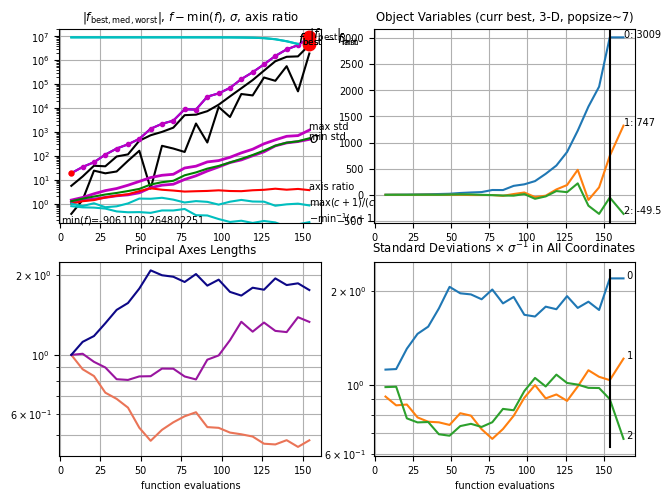

In [29]:
fun2 = cma.ScaleCoordinates(fun, [1000**(-i / 3) for i in range(4)])
xopt2, es2 = cma.fmin2(fun2, x0, sigma0)
cma.plot();


On the 40-dimension ellipsoid function, the saving is much more substantial, namely a factor of about 6 to 7:

In [12]:
xopt40, es40 = cma.fmin2(fun, 40 * [2], sigma0, {'verbose':-9})
xopt0, es0 = cma.fmin2(cma.ScaleCoordinates(fun,
                                            [1000**(-i / 39) for i in range(40)]),
                       40 * [2], sigma0, {'verbose':-9})

In [13]:
es40.result.fbest, es0.result.fbest, es40.result.evals_best / es0.result.evals_best

(1.0729174808445463e-14, 2.7695101639785635e-14, 6.653637069634999)

Without covariance matrix adaptation, the saving from rescaling would be even _much_ more substantial, namely a factor of about $10\,000$, which can be inferred from Figure 10 in [Hansen and Ostermeier (2001)](http://www.cmap.polytechnique.fr/~nikolaus.hansen/publications.html#hansenaost2001).

### Advanced Options Settings
#### Setting the step-size adaptation
Apart from the default cumulative step-size adaptation, another competitive way to adapt the step-size is the two-point step-size adaptation, TPA, see Equations (6)-(8) in [Akimoto and Hansen (2016)](https://hal.inria.fr/hal-01306551).

In [14]:
cma.CMAOptions('sigma')

{'AdaptSigma': 'True  # or False or any CMAAdaptSigmaBase class e.g. CMAAdaptSigmaTPA, CMAAdaptSigmaCSA',
 'CMA_dampsvec_fac': 'np.Inf  # tentative and subject to changes, 0.5 would be a "default" damping for sigma vector update',
 'CMA_dampsvec_fade': '0.1  # tentative fading out parameter for sigma vector update',
 'CMA_stds': 'None  # multipliers for sigma0 in each coordinate, not represented in C, better use `cma.ScaleCoordinates` instead',
 'CSA_squared': 'False  #v use squared length for sigma-adaptation ',
 'scaling_of_variables': 'None  # deprecated, rather use fitness_transformations.ScaleCoordinates instead (or possibly CMA_stds). Scale for each variable in that effective_sigma0 = sigma0*scaling. Internally the variables are divided by scaling_of_variables and sigma is unchanged, default is `np.ones(N)`',
 'tolupsigma': '1e20  #v sigma/sigma0 > tolupsigma * max(eivenvals(C)**0.5) indicates "creeping behavior" with usually minor improvements'}

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=967939, Wed Jan  4 15:54:02 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.986285495587289e+06 1.0e+00 1.13e+00  1e+00  1e+00 0:00.0
    2     16 1.007132970489063e+06 1.4e+00 1.39e+00  1e+00  1e+00 0:00.0
    3     24 5.374298827416338e+04 1.5e+00 1.81e+00  2e+00  2e+00 0:00.0
  100    800 3.869001381245537e-03 1.2e+03 2.09e-02  4e-05  4e-02 0:00.2
  180   1440 2.436434105625448e-15 1.3e+03 3.74e-07  3e-11  4e-08 0:00.4
termination on tolfun=1e-11 (Wed Jan  4 15:54:03 2023)
final/bestever f-value = 1.081953e-15 1.081953e-15
incumbent solution: [1.3111164006469204e-08, 5.215661980990102e-10, -2.8883123765669107e-10, 6.972266150868754e-12]
std deviation: [3.9106284901035484e-08, 3.88020796891621e-09, 3.6626142453507706e-10, 2.977037215621355e-11]


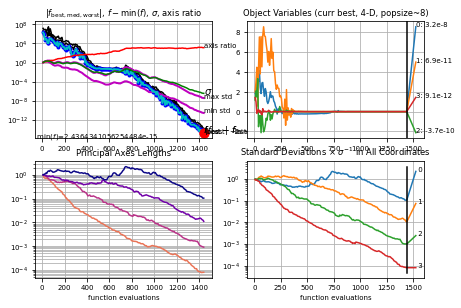

In [15]:
xopt, es = cma.fmin2(fun, x0, sigma0,
                     {'AdaptSigma': cma.sigma_adaptation.CMAAdaptSigmaTPA})
cma.plot();

Without step-size adaptation, the "final" convergence stage of the optimization takes about 3 to 4 times longer (and the effect would become more pronounced in higher dimension):

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=956193, Wed Jan  4 15:54:05 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 9.962147978848995e+05 1.0e+00 1.00e+00  9e-01  1e+00 0:00.0
    2     16 1.842263725898031e+05 1.5e+00 1.00e+00  9e-01  1e+00 0:00.0
    3     24 1.991067597542904e+05 1.8e+00 1.00e+00  9e-01  1e+00 0:00.0
  100    800 3.786642039988560e-01 6.6e+02 1.00e+00  8e-04  5e-01 0:00.2
  200   1600 2.902893196463774e-05 1.2e+03 1.00e+00  6e-06  6e-03 0:00.4
  300   2400 5.047920004973993e-09 1.2e+03 1.00e+00  7e-08  8e-05 0:00.5
  393   3144 1.255062214770326e-12 9.8e+02 1.00e+00  1e-09  1e-06 0:00.6
termination on tolfun=1e-11 (Wed Jan  4 15:54:06 2023)
final/bestever f-value = 2.937319e-13 2.937319e-13
incumbent solution: [-3.990810719499113e-07, 9.938368156030944e-10, 3.5352947536469938e-09, 9.687263176486526e-11]
std deviation: [9.705182229661881e-07, 9.251692713637309e-08, 7.793813819936797e-09, 9.599638347611575e-10

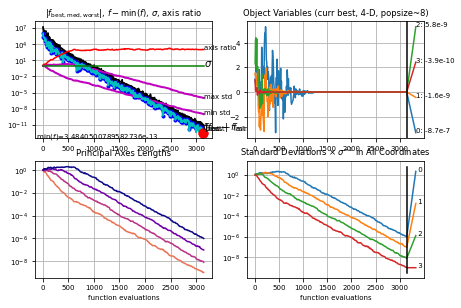

In [16]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'AdaptSigma': False})
cma.plot();

#### Setting different learning rates
A more research related option is the manual setting of learning rates. We can find the relevant options for the covariance matrix update like

In [17]:
cma.CMAOptions('covar')

{'CMA_diagonal': '0*100*N/popsize**0.5  # nb of iterations with diagonal covariance matrix, True for always',
 'CMA_on': '1  # multiplier for all covariance matrix updates',
 'CMA_rankmu': '1.0  # multiplier for rank-mu update learning rate of covariance matrix',
 'CMA_rankone': '1.0  # multiplier for rank-one update learning rate of covariance matrix',
 'tolconditioncov': '1e14  #v stop if the condition of the covariance matrix is above `tolconditioncov`'}

If we want to run CMA-ES only with rank-$\mu$ update, we set the learning rate for the rank-one update to zero. Then, to get a solution of the same quality on the 4-dimensional ellipsoid function, it takes on average about 15% more iterations.

In [18]:
xopt, es = cma.fmin2(fun, x0, sigma0, {'CMA_rankone': 0})

(4_w,8)-aCMA-ES (mu_w=2.6,w_1=52%) in dimension 4 (seed=919867, Wed Jan  4 15:54:07 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      8 1.305959582460722e+05 1.0e+00 1.17e+00  1e+00  1e+00 0:00.0
    2     16 2.919981942028197e+05 1.3e+00 1.31e+00  1e+00  1e+00 0:00.0
    3     24 1.992732385013279e+05 1.4e+00 1.40e+00  1e+00  2e+00 0:00.0
  100    800 1.035888133402810e+00 6.4e+02 1.62e-01  1e-03  6e-01 0:00.1
  200   1600 4.955175471311136e-12 8.5e+02 3.09e-06  2e-09  2e-06 0:00.3
  223   1784 1.134415969557662e-14 8.0e+02 3.21e-07  2e-10  1e-07 0:00.3
termination on tolfun=1e-11 (Wed Jan  4 15:54:08 2023)
final/bestever f-value = 1.174361e-14 1.134416e-14
incumbent solution: [2.2799225989465336e-08, -1.4671046859603233e-09, -6.934343123145891e-10, 7.874044414644658e-11]
std deviation: [1.282962636778195e-07, 1.4226878052254711e-08, 1.411813376746338e-09, 1.7411325636633782e-10]


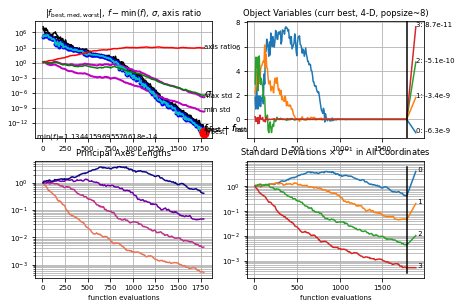

In [19]:
cma.plot();

## See Also

Other [`notebooks and recipes`](https://github.com/CMA-ES/pycma/tree/master/notebooks), as this one, can be found at [https://github.com/CMA-ES/pycma/tree/master/notebooks](https://github.com/CMA-ES/pycma/tree/master/notebooks)

More `notebook-recipes` to come...